The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


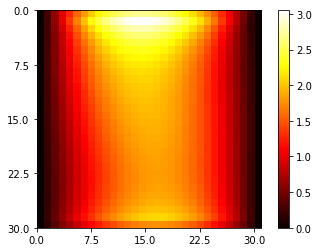

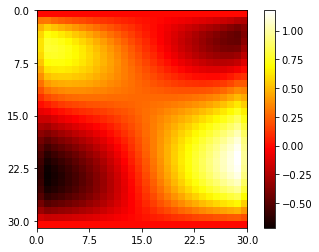

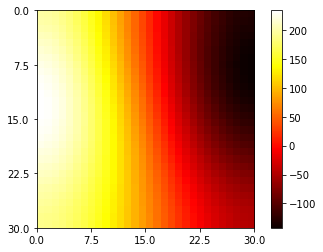

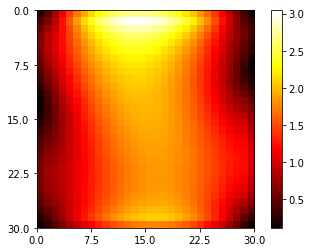

In [21]:
%reset -f
%load_ext autoreload
%autoreload 2

import Odin
from fieldAccess import *
import numpy as np

geom = Odin.createGeometry( 'rectangle', [30,30] )
mesh = Odin.createMesh( geom, res=1 )

movingWallVelocity = 0.2

# make just a list, give a name as optional parameter to flow model
# make this a flowmodeles constructor with kwargs here and then remove simulation instance
myFlowModels = {
    'u' : Odin.TransportModels.staggeredTransport_u,
    'v' : Odin.TransportModels.staggeredTransport_v,
    'p' : Odin.PressureModels.Pressure
}

passiveFields = {}

sim = Odin.Simulation(flowmodels=myFlowModels, mesh=mesh, geometry=geom, passiveFields=passiveFields )


myFields = sim.fieldRegistry
u=myFields['u']
v=myFields['v']
p=myFields['p']

# relates to viscosity:
u.govModel.setDiffusionCoefficient(10)
v.govModel.setDiffusionCoefficient(10)

u.data.fill(0.0)
Odin.defineBoundaryCondition(field=u, boundaryName='top', boundaryType='fixedValue', value=movingWallVelocity)
Odin.defineBoundaryCondition(field=u, boundaryName='bottom', boundaryType='fixedValue', value=0 )
Odin.defineBoundaryCondition(field=u, boundaryName='right', boundaryType='fixedValue', value=0 )
Odin.defineBoundaryCondition(field=u, boundaryName='left', boundaryType='fixedValue', value=0)

v.data.fill(0.0)
Odin.defineBoundaryCondition(field=v, boundaryName='top', boundaryType='fixedValue', value=0)
Odin.defineBoundaryCondition(field=v, boundaryName='bottom', boundaryType='fixedValue', value=0)
Odin.defineBoundaryCondition(field=v, boundaryName='left', boundaryType='fixedValue', value=0 )
Odin.defineBoundaryCondition(field=v, boundaryName='right', boundaryType='fixedValue', value=0)

p.data.fill(0.0)
Odin.defineBoundaryCondition(field=p, boundaryName='top', boundaryType='zeroGradient')
Odin.defineBoundaryCondition(field=p, boundaryName='bottom', boundaryType='zeroGradient')
Odin.defineBoundaryCondition(field=p, boundaryName='left', boundaryType='zeroGradient' )
Odin.defineBoundaryCondition(field=p, boundaryName='right', boundaryType='zeroGradient')


alphaP = 0.2
alphaV = 0.5

for i in range(2):
    u_old = np.copy(u.data)
    v_old = np.copy(v.data)

    u.data = Odin.solve(u)
    v.data = Odin.solve(v)

    p_correction = Odin.solve(p)
    p.data +=  alphaP*p_correction

    u_new = u.data[internal_u] + p.govModel.d_u[internal_u] * ( p_correction[west]- p_correction[east] )
    v_new = v.data[internal_v] + p.govModel.d_v[internal_v] * ( p_correction[south]- p_correction[north] )

    u.data[internal_u] = alphaV*u_new + (1.0-alphaV)*u_old[internal_u]
    v.data[internal_v] = alphaV*v_new + (1.0-alphaV)*v_old[internal_v]

    u.data[internal_u] +=  p.govModel.d_u[internal_u] * ( p_correction[west]- p_correction[east] )
    v.data[internal_v] += p.govModel.d_v[internal_v] * ( p_correction[south]- p_correction[north])

#    u_new = u.data[internal_u] + p.govModel.d_u[internal_u] * ( p_correction[west]- p_correction[east] )


sim.display(u,mesh)
sim.display(v,mesh)
sim.display(p,mesh)


vel = Odin.calcCollocatedVelocityField(u.data, v.data)
velMag = Odin.calcVelocityMagnitude(vel)
sim.display(velMag,mesh)



In [ ]:
# shutting the interpreter down, so I can a fresh instance next time.
# my modules are automatically checked for updates
import os
os._exit(00)